In [7]:
'''
Code for paper
"Discovery of senolytics using machine learning", by Vanessa Smer-Barreto et al, 2023.

This code trains an XGBoost model to perform binary classification of molecules according to their
senolytic action. The code requires the following files:
- list_of_compounds_for_training.csv (for model training)
- list_of_compounds_for_computational_screening.csv (for using the XGBoost model to screen for candadite hits)

Both files should be in the same folder as this notebook.

The predictions given by the model used in the manuscript are given in the last cell and can be used to 
reproduce Figure 2E in the paper. To run, this last cell needs file 
- xgboost_prediction_scores.csv 

'''

# Libraries:

# Maths, data analysis, and graphics 
import seaborn as sn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
import pickle

# Machine learning: models for training, and performance measures
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score
from sklearn.metrics import auc
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score

# Machine learning: models for training, and performance measures
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
import xgboost as xgb

In [8]:
'''
Read list of featurised compounds for model training. The target is the binarised column 
'senolytic' and the features to be used for training are physicochemical descriptors from RDKit. 
'''

df = pd.read_csv('list_of_compounds_for_training.csv', sep=",")

In [9]:
''' 
The dataframe is rid of non-numerical columns, the compound names are set as indexes, and the dataframe is 
shuffled in a randomised manner to ensure a uniform distribution of both classes.  
'''
df = df.drop(['Library', 'Source', 'SMILES'], axis=1)
df = df.set_index('Name')
df = shuffle(df)
X_variant = df.drop(df.columns[[0]], axis=1)
y = df["senolytic"]

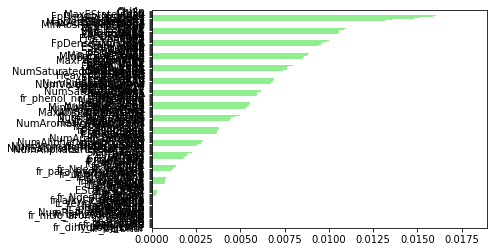

There are 176 features with importance > 0


In [10]:
''' 
Calculation of feature importance as shown in Supplementary Figure 1a, utilising a random forest algorithm.
'''

#Random forest
rf = RandomForestClassifier()
current = make_pipeline(MinMaxScaler(), rf)
current.fit(X_variant,y)

#Feature importance calculation and visualisation
importances_rf = pd.Series(rf.feature_importances_, index = X_variant.columns)
sorted_importances_rf = importances_rf.sort_values()
sorted_importances_rf.plot(kind = 'barh', color = 'lightgreen'); plt.show()

# Write file with feature importance ordered list 
sorted_importances_rf.to_csv('rdkit_importance_features.csv')

#Choice of features with importance > 0 for model training 
sorted_importances_rf = pd.DataFrame({"Importance" : rf.feature_importances_, "Name" : X_variant.columns})
df4 = sorted_importances_rf[sorted_importances_rf["Importance"] > 0.0]
important_features = df4['Name'].to_list()
print("There are", len(important_features), "features with importance > 0")

In [11]:
'''
Crop data to include only features with importance > 0. 
'''

X_variant = df[important_features]

In [12]:
'''
5-fold cross-validation computation of metrics: average ± one standard deviation as in Fig. 2b
'''

Precision = []
Recall = []
Accuracy = []
F1_score = []
std_Precision = []
std_Recall = []
std_Accuracy = []
std_F1_score = []

#current_model = RandomForestClassifier(class_weight = None)
#current_model = SVC(kernel="linear", probability=True, class_weight = 'balanced')
current_model = xgb.XGBClassifier(objective = 'binary:logistic', learning_rate = 0.5, max_depth = 10, 
                                n_estimators = 100, colsample_bytree = 0.5)
    
current = make_pipeline(MinMaxScaler(), current_model)

scores = cross_val_score(current, X_variant, y, cv = None, scoring='precision')
Precision.append(np.mean(scores))
std_Precision.append(np.std(scores))

scores = cross_val_score(current, X_variant, y, cv = None, scoring='recall')
Recall.append(np.mean(scores))
std_Recall.append(np.std(scores))

scores = cross_val_score(current, X_variant, y, cv = None)
Accuracy.append(np.mean(scores))
std_Accuracy.append(np.std(scores))

scores = cross_val_score(current, X_variant, y, cv = None, scoring='f1')
F1_score.append(np.mean(scores))
std_F1_score.append(np.std(scores))

hyperparameters = pd.DataFrame({"<Precision>" : Precision, 
                               "<Recall>": Recall, "<Accuracy>": Accuracy, 
                                "<F1_score>": F1_score, 
                                "std Precision": std_Precision, 
                               "std Recall": std_Recall, 
                                "std Accuracy": std_Accuracy,
                               "std F1_score": std_F1_score})

hyperparameters

,<Precision>,<Recall>,<Accuracy>,<F1_score>,std Precision,std Recall,std Accuracy,std F1_score
0,0.753333,0.204545,0.980182,0.307283,0.208273,0.122624,0.003314,0.160183


In [13]:
'''
Hyperparameter optimisation for xgboost; we optimised tree_depth.
'''

tree_depth = list(range(1, 11))
Precision = []
Recall = []
Accuracy = []
std_Precision = []
std_Recall = []
std_Accuracy = []

for jj in range(len(tree_depth)):
    #Model definition
    current_model = xgb.XGBClassifier(objective = 'binary:logistic', learning_rate = 0.5, max_depth = tree_depth[jj], 
                                n_estimators = 100, colsample_bytree = 0.5)
    
    current = make_pipeline(MinMaxScaler(), current_model)
    
    scores = cross_val_score(current, X_variant, y, cv = None, scoring='precision')
    Precision.append(np.mean(scores))
    std_Precision.append(np.std(scores))

    scores = cross_val_score(current, X_variant, y, cv = None, scoring='recall')
    Recall.append(np.mean(scores))
    std_Recall.append(np.std(scores))

    scores = cross_val_score(current, X_variant, y, cv = None)
    Accuracy.append(np.mean(scores))
    std_Accuracy.append(np.std(scores))
    
hyperparameters = pd.DataFrame({"Tree depth" : tree_depth, "<Precision>" : Precision, 
                               "<Recall>": Recall, "<Accuracy>": Accuracy, "std Precision": std_Precision, 
                               "std Recall": std_Recall, "std Accuracy": std_Accuracy})
hyperparameters = hyperparameters.set_index('Tree depth')
hyperparameters

,<Precision>,<Recall>,<Accuracy>,std Precision,std Recall,std Accuracy
Tree depth,,,,,,
1,0.433333,0.153030,0.977011,0.226078,0.111175,0.002028
2,0.688095,0.275758,0.980975,0.117224,0.144584,0.003217
3,0.646667,0.204545,0.979390,0.293333,0.152873,0.005252
4,0.733333,0.222727,0.980579,0.226078,0.143388,0.004408
5,0.700000,0.206061,0.979391,0.266667,0.111485,0.004780
6,0.700000,0.206061,0.979787,0.266667,0.111485,0.004224
7,0.733333,0.187879,0.980182,0.226078,0.120966,0.003543
8,0.700000,0.169697,0.979389,0.244949,0.127183,0.003674
9,0.766667,0.187879,0.980182,0.200000,0.120966,0.003314


In [14]:
'''
Train-test-validation split for model training and performance evaluation.
'''
X_train, X_test, y_train, y_test = train_test_split(X_variant, y, 
                                                    test_size = 0.3, random_state = 16,
                                                   stratify = y)

In [15]:
'''
Model selection. We chose the xgboost model for training, computational screening, and experimental validation
of top predictions. To use either of the next two best performing models, uncomment the line of interest, or you
can also add a model of your choice. 
'''
current_model = xgb.XGBClassifier(objective = 'binary:logistic', learning_rate = 0.5, max_depth = 10, 
                            n_estimators = 100, colsample_bytree = 0.5)

# SVM
#current_model = SVC(kernel="linear", probability=True, class_weight='balanced')

# Random forest
#current_model = RandomForestClassifier()

Confusion matrix and validation metrics in test set
[[740   0]
 [ 16   1]]
Accuracy: 0.9788639365918098
FPR: 0.0
Precision: 1.0
Recall: 0.058823529411764705
F1_score: 0.1111111111111111
ROC AUC: 0.5294117647058824
Precision-Recall AUC: 0.2391712845397922


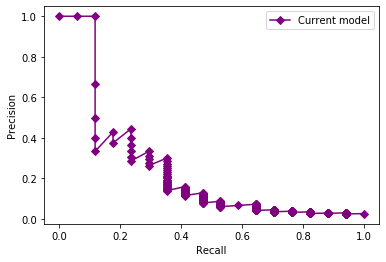

In [16]:
'''
Training of XGBoost model for later prediction of compounds, and performance metrics quantification 
with a 70:30 data split as in Fig. 2c
'''

current = make_pipeline(MinMaxScaler(), current_model)

print('Confusion matrix and validation metrics in test set')
current.fit(X_train,y_train)
y_pred = current.predict(X_test)
confusion = confusion_matrix(y_test, y_pred)
print(confusion)
print('Accuracy:', current.score(X_test, y_test))
print('FPR:', confusion[0,1]/(confusion[0,0] + confusion[0,1]))
print('Precision:', confusion[1,1]/(confusion[1,1] + confusion[0,1]))
print('Recall:', confusion[1,1]/(confusion[1,1] + confusion[1,0]))
print('F1_score:', confusion[1,1]/(confusion[1,1] + 0.5*(confusion[0,1]+confusion[1,0])))
print('ROC AUC:', roc_auc_score(y_test, y_pred))

# Precision-recall curve
y_test_proba = current.predict_proba(X_test)[:,1]
precision, recall, _ = precision_recall_curve(y_test, y_test_proba)
plt.plot(recall, precision, marker='D', color = 'purple', label='Current model')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend()
print("Precision-Recall AUC:", auc(recall, precision))

In [20]:
'''
Computational screen. Data is provided in file 'list_of_compounds_for_computational_screening.csv' but other 
molecules can be tested if the physicochemical descriptors matrix is provided for them. 
'''
unlabeled_senolytics = pd.read_csv('list_of_compounds_for_computational_screening.csv', sep=",")
unlabeled_senolytics = shuffle(unlabeled_senolytics)

unlabeled_senolytics_prob = pd.DataFrame({"Name" : unlabeled_senolytics['Name'], 
                            "dummy_column" : np.zeros((len(unlabeled_senolytics)), dtype=int)
                                  })
unlabeled_senolytics_prob = unlabeled_senolytics_prob.set_index('Name')
unlabeled_senolytics = unlabeled_senolytics.set_index('Name')

X_test = unlabeled_senolytics[important_features]
y_proba = current.predict_proba(X_test)[:,1]

unlabeled_senolytics_prob['probability'] = y_proba
unlabeled_senolytics_prob = unlabeled_senolytics_prob.drop(unlabeled_senolytics_prob.columns[[0]], axis=1)

#Probability of models being senolytic
unlabeled_senolytics_prob.to_csv('prediction_scores_senolytics_pipeline.csv', sep=",")

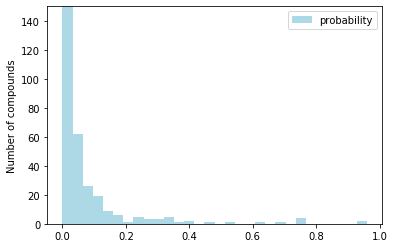

In [21]:
'''
Visualisation of computational screen results - this is equivalent to Fig 2d in paper.
'''

unlabeled_senolytics_prob.plot(kind = 'hist', bins = 30, color = 'lightblue')
plt.ylabel('Number of compounds')
plt.ylim([0, 150])
plt.show()

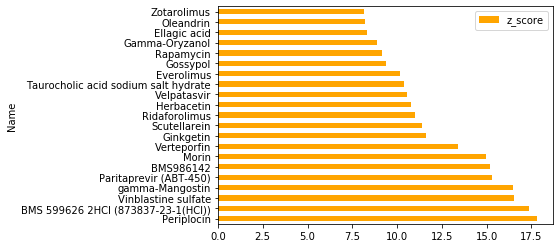

In [22]:
'''
These are the top hits chosen for experimental validation, - this is equivalent to Fig 2e in paper.
'''

predictions_used_in_publication = pd.read_csv('xgboost_prediction_scores.csv', sep=",")
predictions_used_in_publication = predictions_used_in_publication.set_index('Name')

df5 = predictions_used_in_publication[predictions_used_in_publication["z_score"] >= 8]
df5 = df5.drop(['probability'], axis=1)
df5.plot(kind = 'barh', color = 'orange'); plt.show()